## Задача проекта:
разработать модель предсказания успешности стартапа (закроется или нет)


## Описание данных

Датасет состоит из двух файлов: учебный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак статуса, указывающий на то, завершился стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

`kaggle_startups_train_01.csv` - информация (53 000) стартапах, которые будут использованы в качестве обучающих данных.

`kaggle_startups_test_01.csv` - информация (13 000) стартапах, которые будут использованы в качестве тестовых данных. 


`name` - Название стартапа

`category_list` - Список категорий, к которым относится стартап

`funding_total_usd` - Общая сумма финансирования в долларах США

`status` - Статус стартапа (закрыт или действует)

`country_code` - Код страны

`state_code` - Код штата

`region` - Регион

`city` - Город

`finance_rounds` - Количество раундов финансирования

`found_at` - Дата основания

`first_funding_at` - Дата первого раунда финансирования

`last_funding_at` - Дата последнего раунда финансирования

`closed_at` - Дата закрытия стартапа (если применимо)

`lifetime` - Время существования стартапа в днях

## Импорт библиотек и загрузка данных

In [1]:
!pip install imblearn -q
!pip install phik -q
!pip install seaborn -q
!pip install -U scikit-learn -q

In [2]:

#матрица корреляции
from sklearn.metrics import confusion_matrix

import pandas as pd

import numpy as np

from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline              
from sklearn.compose import ColumnTransformer

#классы для обработки данных для модели
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

#модели
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, train_test_split

In [168]:
train =  pd.read_csv(r'kaggle_startups_train_28062024.csv')
test =  pd.read_csv(r'kaggle_startups_test_28062024.csv')

In [169]:
train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Меняем типы данных

In [171]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [172]:
train['founded_at'] = train['founded_at'].astype("datetime64[ns]")
train['first_funding_at'] = train['first_funding_at'].astype("datetime64[ns]")
train['last_funding_at'] = train['last_funding_at'].astype("datetime64[ns]")
train['closed_at'] = train['closed_at'].astype("datetime64[ns]")
train.info()



test['first_funding_at'] = test['first_funding_at'].astype("datetime64[ns]")
test['last_funding_at'] = test['last_funding_at'].astype("datetime64[ns]")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

## Предобработка данных

Заполним пропуски в столбце closed_at, в ней пропущенные значения укажем как дату сбора данных и создадим новый признак с временем жизни стартапа `lifetime`

In [173]:
train.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)
train['lifetime'] = (train.closed_at-train.founded_at).dt.days

In [174]:
train.head(10)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
 13  lifetime           52516 non-null  int64         
dtypes: dat

Проверим данные на наличие явных  дубликатов

In [175]:
train.duplicated().value_counts()

False    52516
Name: count, dtype: int64

Явных дубликатов нет.

Создадим новый признак `delta_funding_at`. Из даты основания вычтем дату первого раунда финансирования

In [176]:
train['delta_funding_at'] = (train.last_funding_at-train.first_funding_at).dt.days
test['delta_funding_at'] = (test.last_funding_at-test.first_funding_at).dt.days

In [177]:
train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,delta_funding_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,1051
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,0
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452,0
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,0
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,0
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,1289
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,576


Удалим пропущенные значения в столбце `funding_total_usd` и добавим нрвый признак `log_funding_total_usd` натуральнй логарифм от общей суммы финансирования

In [178]:
train = train.dropna(subset=['funding_total_usd'])
train['log_funding_total_usd'] = np.log(train['funding_total_usd'])

## Построим матрицу корреляции

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'delta_funding_at', 'log_funding_total_usd']


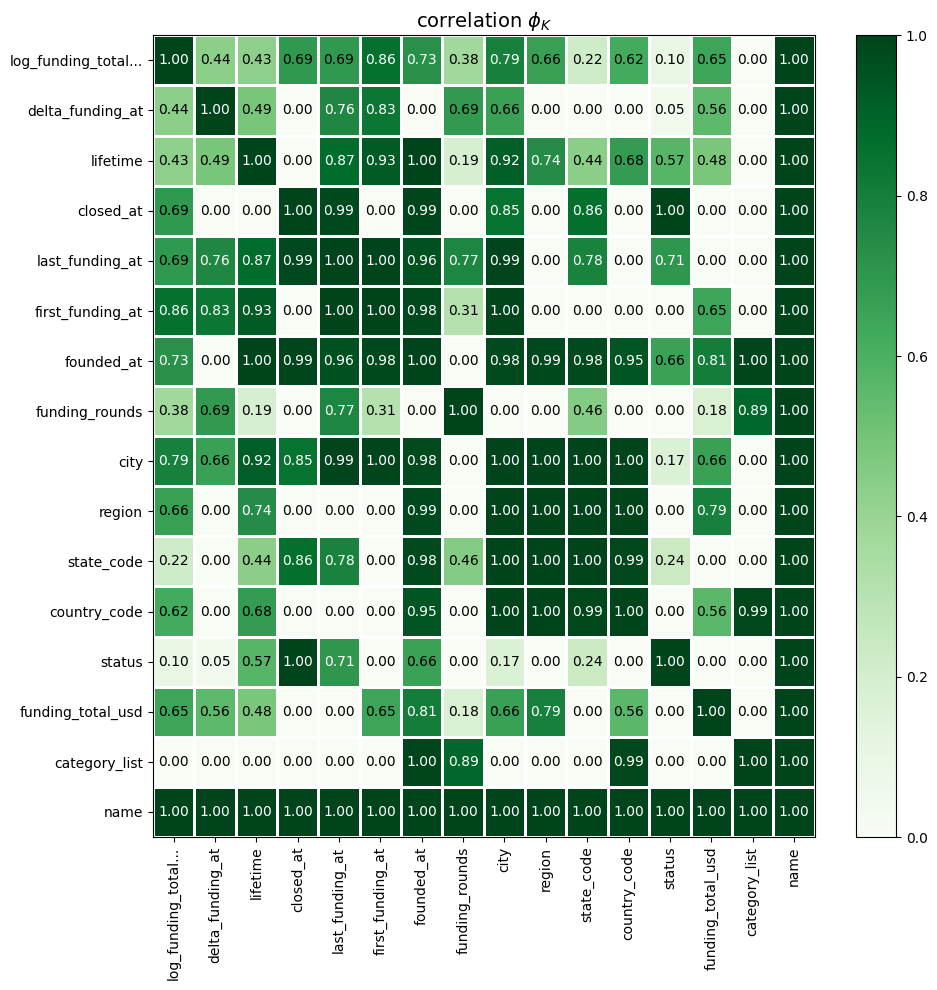

In [60]:
phik_overview = train.sample(1000).phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

Признаки дат не несут в себе полезной информации для обучения моделей, как и информация с географическими данными. Для обучения моделей оставим данные о стране, финансировании, и времени жизни стартапа.

## Подготовка датафрейма перед обучением модели

Создаем новый дф с нужными нам столбцами

In [179]:
df= train[['country_code', 'funding_total_usd', 'funding_rounds', 'lifetime', 'delta_funding_at', 'status',
           'log_funding_total_usd']]
df.dropna(inplace=True)


Фиксируем значение `random_state`

In [180]:
RANDOM_STATE = 1337

Кодируем целевой признак 

In [181]:
df.loc[df['status']=='operating', 'status'] = 1
df.loc[df['status']=='closed', 'status'] = 0

In [182]:
df['status'] = df['status'].astype(int)
df

,country_code,funding_total_usd,funding_rounds,lifetime,delta_funding_at,status,log_funding_total_usd
0,CHE,828626.0,2,2998,1310,1,13.627524
1,USA,42935019.0,4,4748,1393,1,17.575198
2,USA,35456381.0,3,4383,681,1,17.383814
5,USA,4300000.0,1,2452,0,1,15.274126
6,USA,90000000.0,1,6575,0,1,18.315320
...,...,...,...,...,...,...,...
52510,CHN,205600000.0,2,6209,2606,1,19.141443
52512,IND,500000.0,1,1590,0,1,13.122363
52513,USA,50000.0,3,2741,566,1,10.819778
52514,USA,13000000.0,6,7336,1918,1,16.380460


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38771 entries, 0 to 52515
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country_code           38771 non-null  object 
 1   funding_total_usd      38771 non-null  float64
 2   funding_rounds         38771 non-null  int64  
 3   lifetime               38771 non-null  int64  
 4   delta_funding_at       38771 non-null  int64  
 5   status                 38771 non-null  int64  
 6   log_funding_total_usd  38771 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 2.4+ MB


In [184]:
df = df.reset_index(drop=True) #обнуляем индексы

In [185]:
X = df[['country_code', 'funding_total_usd', 'funding_rounds', 'delta_funding_at', 'log_funding_total_usd', 'lifetime']]
y = df['status']

In [186]:
X.count()

country_code             38771
funding_total_usd        38771
funding_rounds           38771
delta_funding_at         38771
log_funding_total_usd    38771
lifetime                 38771
dtype: int64

In [187]:
df['status'].value_counts()

status
1    35735
0     3036
Name: count, dtype: int64

Так как в дф явный дисбаланс классов, займемся оверсемплингом

In [188]:
sm = SMOTENC(random_state=RANDOM_STATE, categorical_features=['country_code'], sampling_strategy=0.25)
X, y = sm.fit_resample(X, y)

In [189]:
y.value_counts()

status
1    35735
0     8933
Name: count, dtype: int64

Разделяем данные на тестовую и тренеровочную выборки

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Создаем списки категориальных и численных столбцов

In [191]:
ohe_columns = ['country_code']
num_columns = ['funding_total_usd', 'funding_rounds', 'delta_funding_at', 'log_funding_total_usd', 'lifetime']

## Создаем пайплайн и получаем предсказания модели

In [192]:
#создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

#гиперпараметры для моделей + перебор методов масштабирования
param_grid = [
    
    {
        'models' : [RandomForestClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        
    }
]

In [75]:
gridsearch = GridSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring='balanced_accuracy',
    #random_state=RANDOM_STATE,
    n_jobs=-1
)
gridsearch.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gridsearch.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', gridsearch.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code']),
                                                 ('num', StandardScaler(),
                                                  ['funding_total_usd',
                        

In [193]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  delta_funding_at   13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 1.2+ MB


Заполняем пропуски в столбце `funding_total_usd` медианным значением

In [194]:
test['funding_total_usd'].isna().value_counts()

funding_total_usd
False    10547
True      2578
Name: count, dtype: int64

In [195]:
test['funding_total_usd'] = test['funding_total_usd'].fillna(test['funding_total_usd'].median())
test['log_funding_total_usd'] = np.log(test['funding_total_usd'])

In [196]:
test['funding_total_usd'].isna().value_counts()

funding_total_usd
False    13125
Name: count, dtype: int64

In [205]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          12534 non-null  object        
 2   funding_total_usd      13125 non-null  int64         
 3   country_code           11743 non-null  object        
 4   state_code             11430 non-null  object        
 5   region                 11536 non-null  object        
 6   city                   11538 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  delta_funding_at       13125 non-null  int64         
 12  log_funding_total_usd  13125 non-null  float64       
 13  s

Получаем предсказания

In [206]:
gridsearch.predict(test)

array([1, 0, 1, ..., 1, 1, 1])

Создаем новый дф с предсказаниями

In [207]:
df = pd.DataFrame({'name' : test['name'], 'status' : gridsearch.predict(test)})

In [208]:
df.head()

,name,status
0,Crystalsol,1
1,JBI Fish & Wings,0
2,COINPLUS,1
3,Imagine Communications,1
4,DNA13,1


In [209]:
df.status.value_counts()

status
1    11807
0     1318
Name: count, dtype: int64

Изменяем порог классификции

In [213]:
y_pred = np.where(gridsearch.predict_proba(test)[:,1] > 0.4, 1, 0)
df_new = pd.DataFrame({'name' : test['name'], 'status' : y_pred})
df_new.loc[df_new['status'] ==1, 'status'] = 'operating'
df_new.loc[df_new['status'] ==0, 'status'] = 'closed'
df_new.status.value_counts()

status
operating    11958
closed        1167
Name: count, dtype: int64

Делаем столбец `name` индексом

In [115]:
df_new = df_new.set_index('name')

Сохраняем дф

In [116]:
df_new.to_csv('g0000L_4.csv')

## Вывод:
- загрузили данные, изменили тип данных на корректный
- заполнили пропуски в `closed_at` датой сбора данных
- создали новые признаки `lifetime`, `delta_funding_at`
- удалили строки в дф `train` с пропущеными значениями
- построили матрицу корреляции и отобрали признаки для обучения модели
- закодировали целевой признак
- добавили в дф синтетические данные для устранения сильного дисбаланса
- созздали пайплайн для обучения модели
- заполнили пропуски в тренировочнеом датасете в столбце `funding_total_usd` на медианное значение
- получили предсказание
- изменили порог классификации
- собрали предсказания и названия стартапов в один дф 